# Importando bibliotecas

In [119]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch.unitroot import PhillipsPerron as pp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Importando base de dados formatada

## 1.1 Tratando os dados internos

In [120]:
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d')

data = pd.read_csv('data/transformed/2000_2021_Brazilian_Northeast_Region_daily_MW_instantaneous_maximum_demand_series.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
data['year']  = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day']   = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['weekday'] = data['date'].dt.weekday
data.head()

,value,date,year,month,day,hour,weekday
index,,,,,,,
2000-01-01,6205.0,2000-01-01,2000,1,1,0,5
2000-01-02,6797.0,2000-01-02,2000,1,2,0,6
2000-01-03,7024.0,2000-01-03,2000,1,3,0,0
2000-01-04,6921.0,2000-01-04,2000,1,4,0,1
2000-01-05,7025.0,2000-01-05,2000,1,5,0,2


# 2. Exploração de dados analíticos

## 2.1 Dados no tempo / Gráfico geral

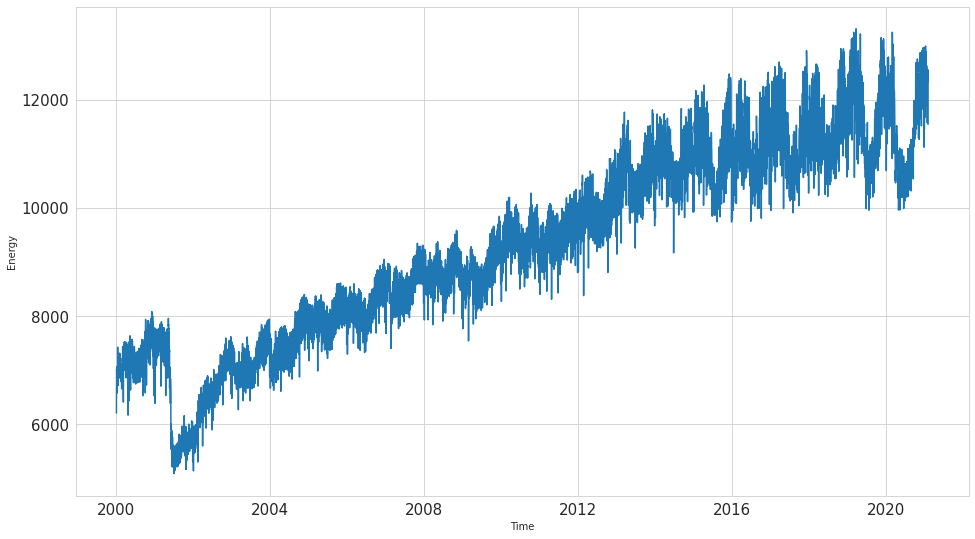

In [121]:
plt.rcParams["figure.figsize"] = [16,9] # dimenção do gráfico
plt.ylabel('Energy') #y
plt.xlabel('Time') #x
plt.plot(data['value']) # impressão dos dados

## 2.2 Informações estatisticas gerais dos dados

In [122]:
describe = data['value'].describe() # descrição dos dados estatisticos
mode = data['value'].mode() #moda
variant = data['value'].var() #variancia
print(f"Variant: {variant}")
print(f"Mode: {mode}")
for key in describe.keys():
    print(f"{key}: {describe[key]}") #outros dados

Variant: 3292779.4518329976
Mode: 0    7160.0
1    7232.0
2    7319.0
3    7434.0
dtype: float64
count: 7701.0
mean: 9393.276347487339
std: 1814.601733668575
min: 5087.9
25%: 7976.7
50%: 9324.78
75%: 10914.15
max: 13306.963


## 2.3 Curva normal do gráfico

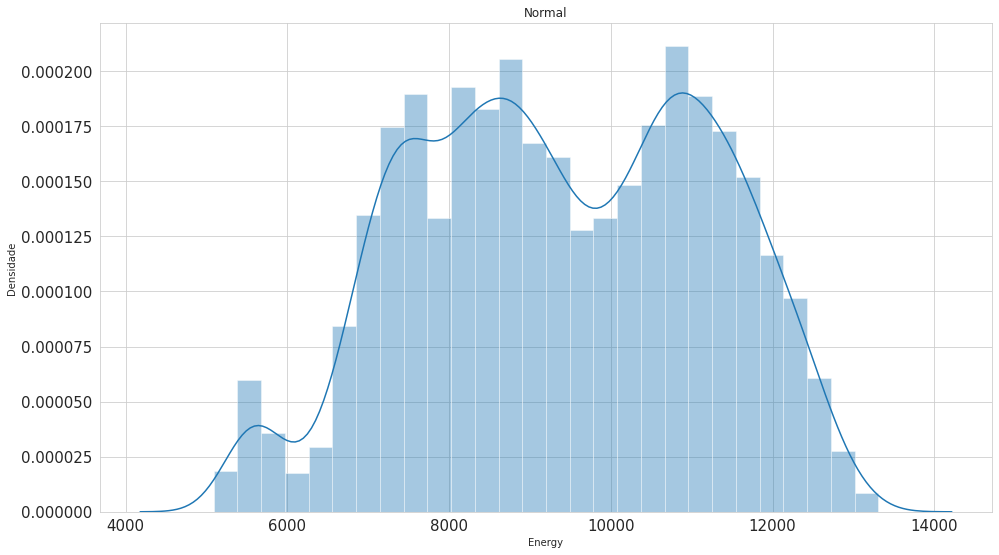

In [123]:
ax = sns.distplot(data['value'], kde=True) # criando a normal
ax.set(xlabel= 'Energy', ylabel='Densidade', title='Normal')
plt.show()

## 2.4 Line

Permite ver dados dos meses ao decorrer do tempo

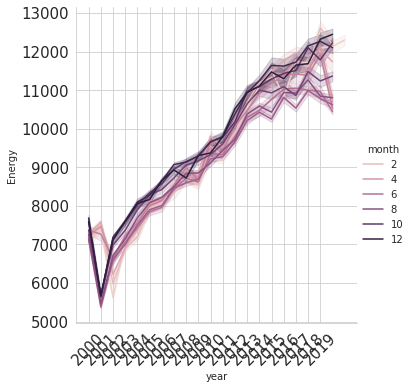

In [124]:
# amostragem de dados por mês em forma de linha do ano de 2000 a 2021
sns.relplot(data=data, x="year", y="value", hue="month", kind='line')
plt.ylabel('Energy')
plt.xticks(np.arange(2000, 2020, 1), rotation=45)
plt.show()
# data.hist(figsize=(15,12), column='value', by='month', bins=25)

## 2.5 Box-plot

Permiter ver as medianas e os quartis. Importante para ver como os dados estão distribuidos por ano.

Text(0, 0.5, 'Energy')

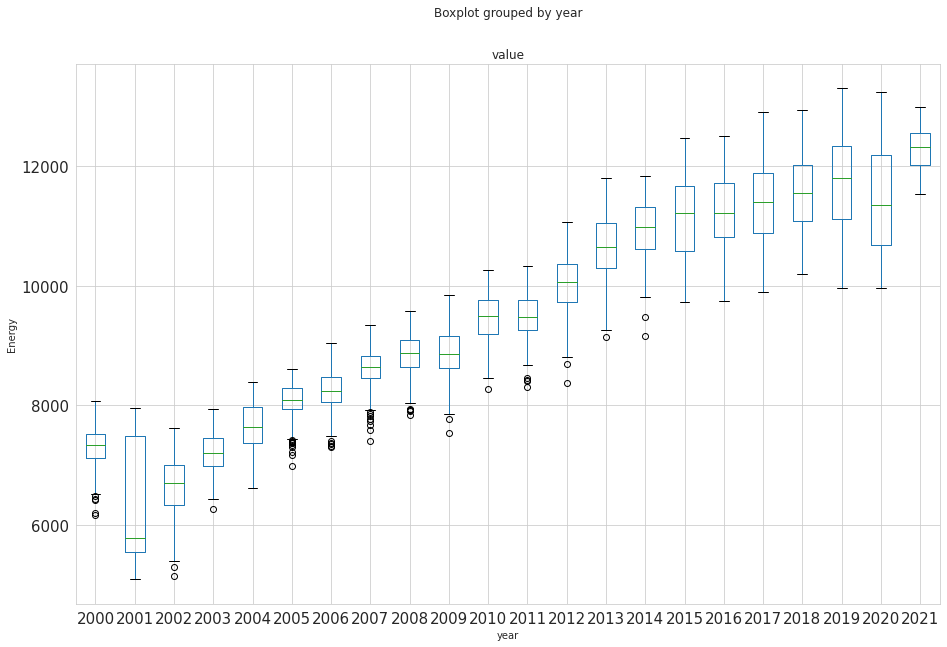

In [125]:
data.boxplot(figsize=(15,10), by='year', column=['value']) # por ano
plt.ylabel('Energy')

# 3. Transformata

## 3.1 Transformada Box-Cox

A transformação de Box-Cox faz uma curva ficar normalmente distribuida, assim permitindo o usuario a fazer uma serie de testes que só podem ser usados em séries distribuidas assim.

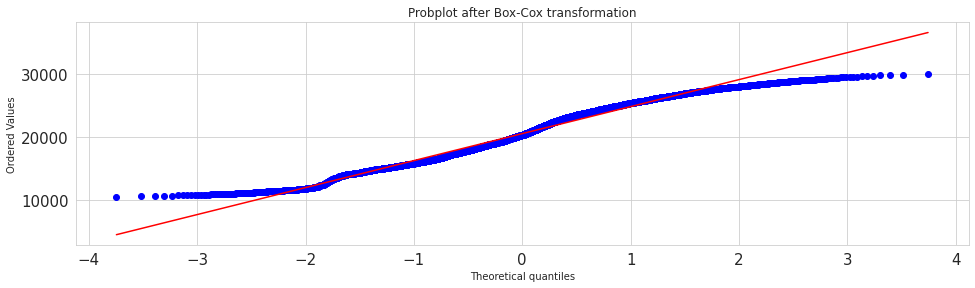

In [126]:
fig = plt.figure()
# ax1 = fig.add_subplot(211)
x = stats.loggamma.rvs(5, size=500) + 5
# prob = stats.probplot(data['value'], dist=stats.norm, plot=ax1)
# ax1.set_xlabel('')
# ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(data['value'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

## 3.2 Transformada Log

A transformação Log diminui o vies dos dados.

None


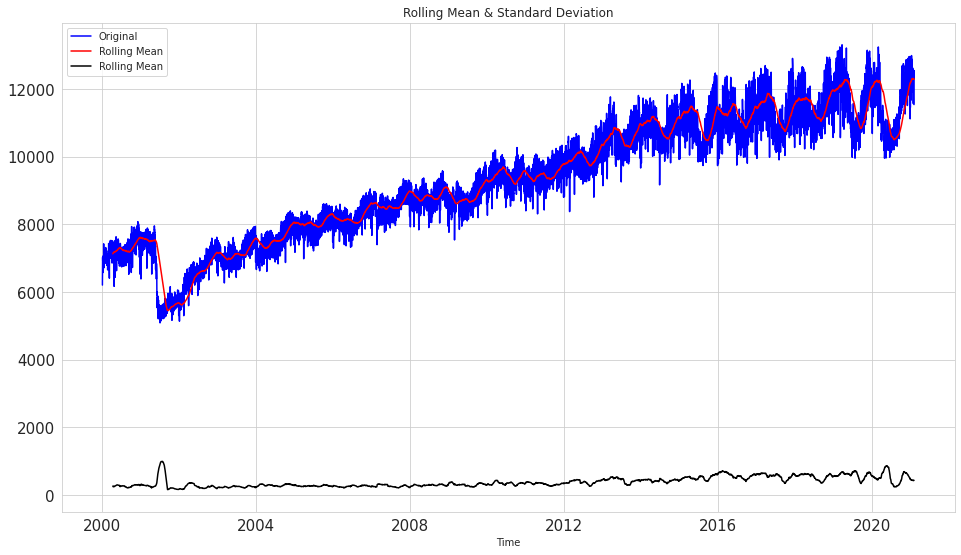

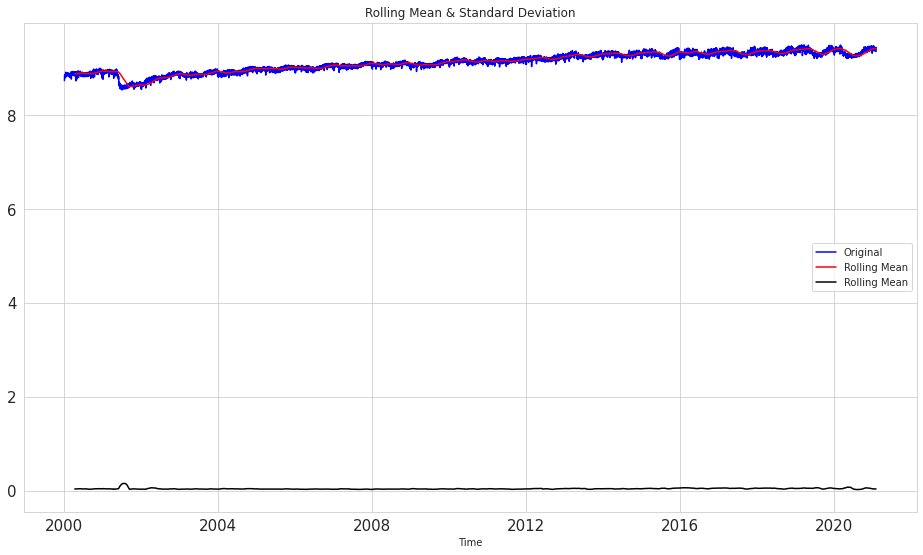

In [127]:
v_log = np.log(data['value']) # criando a transformada ln
data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
value = data['value']
print(pd.infer_freq(value.index))

def test_stationarity(timeseries, window_size=100):

    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window_size).mean() # media da transformada
    rolling_std  = timeseries.rolling(window_size).std() # desvio

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Time')
    plt.show()

test_stationarity(data['value'])

test_stationarity(v_log)
# v_log.to_csv('data/exported/transformed_log.csv')

# 4. Decomposição

Divide serie temporal em tendencia, sazonalidade e aleatoriedade.

- Tendencia: Permite checar se serie temporal tem um padrão de aumento/diminuição dos valores com o tempo;
- Sazonalidade: Representa a variação recorrente(anual, mensal, semanal, ...);

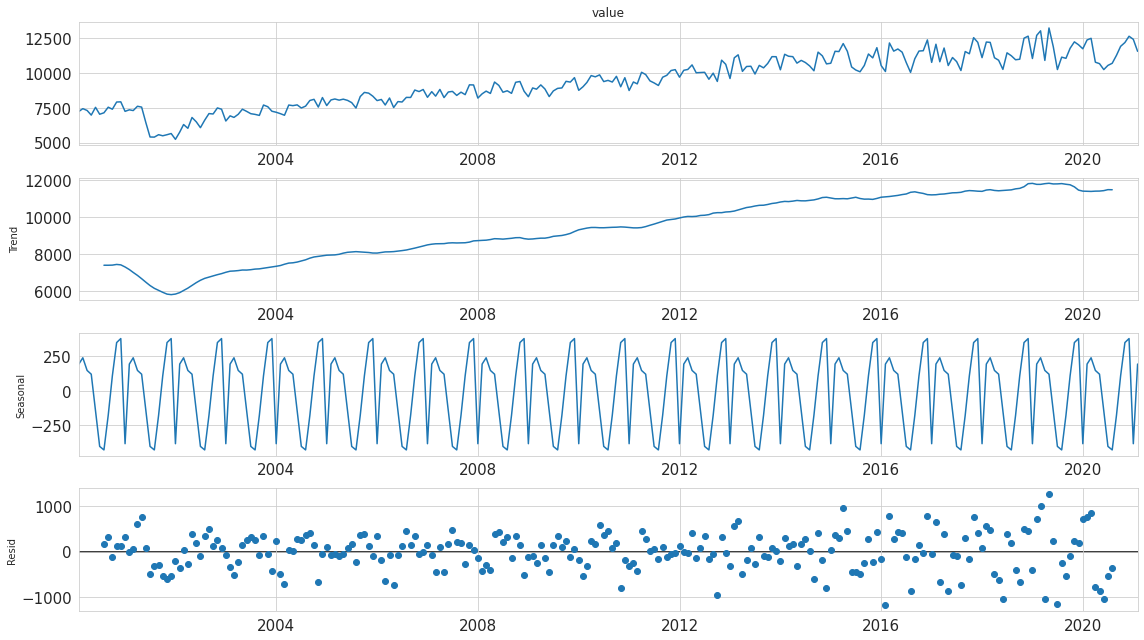

In [128]:
data.sort_index(inplace=True)
data.drop(['date', 'year', 'month', 'day', 'hour', 'weekday'],inplace=True,axis=1)

decomposition = sm.tsa.seasonal_decompose(data.value.asfreq('m'), model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()

# 5. Testes de estacionaridades

Finalidade: Determinar estacionariedade de uma série temporal.

## 5.1 Teste KPPS

In [129]:
series = data['value']
statistic, p, lags, values = sm.tsa.stattools.kpss(series, 'c')
print(f"Test statistic: {statistic}")
print(f"P Value: {p}")
print(f"Lags: {lags}")
for key in values.keys():
    print(f"{key}: {values[key]}")

Test statistic: 19.702133400567376
P Value: 0.01
Lags: 36
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


## 5.2 Teste PP

In [130]:
pp(series)

Test Statistic,-7.048
P-value,0.000
Lags,36


## 5.3 Teste de Dickey Fuller

In [131]:
statistic, p, lags, dont_know, values, test = sm.tsa.adfuller(series.head(10000))
print(f"Test statistic: {statistic}")
print(f"P Value: {p} ???")
print(f"Lags: {lags}")
for key in values.keys():
    print(f"{key}: {values[key]}")

Test statistic: -1.3110665899177067
P Value: 0.6240942496353336 ???
Lags: 35
1%: -3.4312034235233315
5%: -2.8619171497798384
10%: -2.5669707523119336


# 6. Persistência

O que o modelo de persistencia faz?

O modelo de persistencia fala que o valor de n é igual ao de n + 1.

In [132]:
split_date = '1/1/2019 12:00:00 AM'
test  = data[split_date : ]
train = data[ : split_date]

test.head()

,value
index,
2019-01-01,10703.021
2019-01-02,11667.777
2019-01-03,12121.480
2019-01-04,12469.997
2019-01-05,11794.023


#### Concatenate train and test series to plotting

In [133]:
train = train['value']
test = test['value']
series = pd.concat([train, test], axis=0)
series

index
2000-01-01     6205.000
2000-01-02     6797.000
2000-01-03     7024.000
2000-01-04     6921.000
2000-01-05     7025.000
                ...    
2021-01-27    12308.892
2021-01-28    12550.095
2021-01-29    12413.574
2021-01-30    11988.032
2021-01-31    11540.266
Name: value, Length: 7702, dtype: float64

#### Prepare data

O resultado do modelo de persistencia da a baseline. Basicamente permite comparar outros modelos com o seu resultado para assim checar sua eficiencia.

Vantangens do modelo de persistencia:
- Simples
- Rapido
- Facil de replicar

In [134]:
def persistence(last_ob, n_steps):
    return [last_ob for i in range(n_steps)]


test = test.values
series = series.values
train = [x for x in train]

# Number of multi-step
n_steps = 7

# Store multi-step forecasts
forecasts = list()
forecasts_exp = list()

# Number of multi-step forecasts
n_forecasts = len(test) - n_steps + 1

# Walk-forward validation
for i in range(n_forecasts):
    # Make a multi-step forecast
    last_ob = train[-1]
    yhat = persistence(last_ob, n_steps)

    # Store the multi-step forecast
    forecasts.append(yhat)

    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)
    forecasts_exp.append([yhat[0], obs])

print("Ultimos 10 valores:")
for item in forecasts_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

Ultimos 10 valores:
Predito=11936.303, Esperado=12115.408
Predito=12115.408, Esperado=11904.916
Predito=11904.916, Esperado=12622.064
Predito=12622.064, Esperado=12365.629
Predito=12365.629, Esperado=12258.734
Predito=12258.734, Esperado=12175.406
Predito=12175.406, Esperado=12367.506
Predito=12367.506, Esperado=11874.637
Predito=11874.637, Esperado=11568.613
Predito=11568.613, Esperado=12271.288


#### Evaluate the forecasts

In [135]:
# Evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_steps,sum_mape=None):
    sum_rmse = 0
    sum_mape = 0
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]

        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        mape = sqrt(mean_absolute_error(ytrue_ts, ypred_ts))
        sum_rmse += rmse
        sum_mape += mape
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape}") #erros entre a predição e teste

    print(f"Média do RMSE: {sum_rmse/n_steps}")
    print(f"Média do MAPE: {sum_mape/n_steps}")

evaluate_forecasts(test, forecasts, n_steps)

t+1 RMSE: 451.3939283867671 | MAPE: 18.460742166087236
t+2 RMSE: 579.7399339017505 | MAPE: 21.208781967375746
t+3 RMSE: 626.0272378750191 | MAPE: 21.965982297791243
t+4 RMSE: 635.4743306612729 | MAPE: 22.052338086456164
t+5 RMSE: 627.5425299599117 | MAPE: 21.999409624113184
t+6 RMSE: 580.442774480436 | MAPE: 21.100304261955323
t+7 RMSE: 479.562001051974 | MAPE: 18.85219128913444
Média do RMSE: 568.5975337595902
Média do MAPE: 20.805678527559046


## 6.1 Predições com multiplos passos

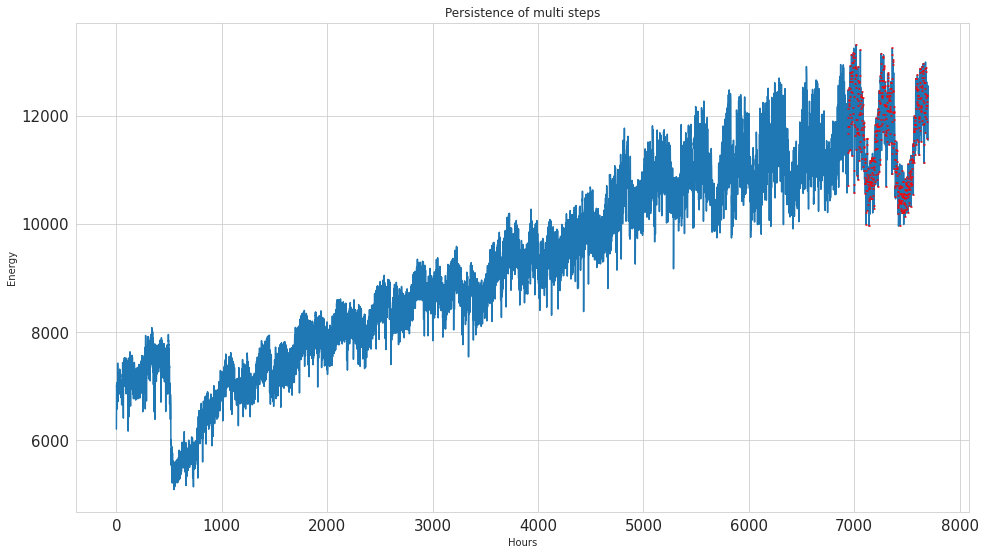

In [136]:
# Plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, test):
    # Plot the entire dataset in blue
    x_points = []
    y_points = []
    plt.plot(series)

    # Plot the forecasts in red
    for i in range(len(forecasts)):
        # Start offset for x-axis
        off_s = len(series) - len(test) + i - 1

        # End offset for x-axis
        off_e = off_s + len(forecasts[i]) + 1

        # Indexes of x-axis for multi-step forecasts
        xaxis = [x for x in range(off_s, off_e)]
        # x_points.append(xaxis)
        # xaxis = np.array(xaxis)

        # Values of muti-step fotecasts
        yaxis = [series[off_s]] + forecasts[i]
        # y_points.append(yaxis)
        # yaxis = np.array(yaxis)
        plt.plot(xaxis, yaxis, color='red')

        # sns.lineplot(data=xaxis, color='blue')
        # sns.lineplot(data=yaxis, color='red')

    # Show the final plot
    plt.ylabel('Energy')
    plt.xlabel('Hours')
    plt.title('Persistence of multi steps')
    plt.show()


plot_forecasts(series, forecasts, test)

## 6.2 Persistência com um passo

In [137]:
pred_exp = list()
predictions = list()
for i in range(len(test)):
    # Predict
    yhat = train[-1]
    # Store forecast in list of predictions
    predictions.append(yhat)
    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)
    pred_exp.append([yhat, obs])
    # print(f">Predicted={yhat}, Expected={obs}")

#### Performance

In [138]:
rmse = sqrt(mean_squared_error(test, predictions))
mape = sqrt(mean_absolute_error(test, predictions))
print('RMSE: %.3f | MAPE: %3.f' % (rmse, mape))
print("Ultimos 10 valores:")
for item in pred_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

RMSE: 454.048 | MAPE:  19
Ultimos 10 valores:
Predito=12175.406, Esperado=12367.506
Predito=12367.506, Esperado=11874.637
Predito=11874.637, Esperado=11568.613
Predito=11568.613, Esperado=12271.288
Predito=12271.288, Esperado=12550.309
Predito=12550.309, Esperado=12308.892
Predito=12308.892, Esperado=12550.095
Predito=12550.095, Esperado=12413.574
Predito=12413.574, Esperado=11988.032
Predito=11988.032, Esperado=11540.266


#### Predito vs Esperado

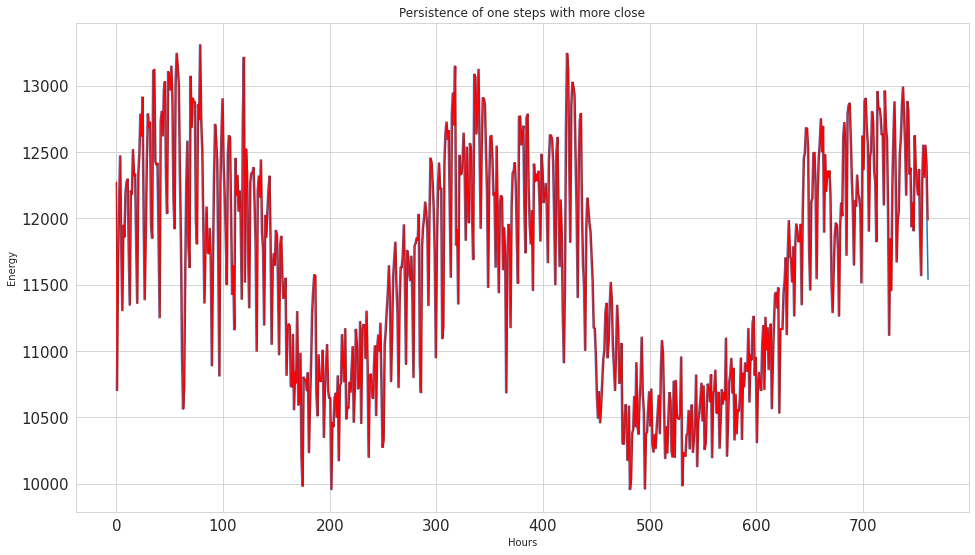

In [139]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.ylabel('Energy')
plt.xlabel('Hours')
plt.title('Persistence of one steps with more close')
plt.show()

# 7. Suavização Exponencial


In [140]:
# precisa colocar as datas que o professor pediu para o treino e teste
split_date = '30/12/2019 12:00:00 AM'
test = data[split_date : ]
train = data[ : split_date]

train_v = train['value']
test_v = test['value']

test_vv = test_v.values
train_vv = [x for x in train_v]

pred = list()
pred_exp = list()

## 7.1 Suavização Exponêncial Simples

t+1 RMSE: 377.6020883999617 | MAPE: 17.280235649657246
t+2 RMSE: 456.05457355236 | MAPE: 18.831068076661406
t+3 RMSE: 491.56316862412655 | MAPE: 19.547937401834243
t+4 RMSE: 486.5623179983567 | MAPE: 19.31542320671208
t+5 RMSE: 477.1919116141653 | MAPE: 19.27975410144709
t+6 RMSE: 469.3164431843596 | MAPE: 19.09325300263606
t+7 RMSE: 458.2999231652559 | MAPE: 18.856145949998314
Média RMSE: 459.5129180769409
Média MAPE: 18.88625962699235
Ultimos 10 valores:
Predito=12132.630853310762, Esperado=12115.408
Predito=12122.297141324305, Esperado=11904.916
Predito=11991.86845652972, Esperado=12622.064
Predito=12369.98578261189, Esperado=12365.629
Predito=12367.371713044757, Esperado=12258.734
Predito=12302.189085217902, Esperado=12175.406
Predito=12226.119234087162, Esperado=12367.506
Predito=12310.951293634864, Esperado=11874.637
Predito=12049.162717453946, Esperado=11568.613
Predito=11760.832886981578, Esperado=12271.288


Text(0.5, 1.0, 'Holt Method with multi steps')

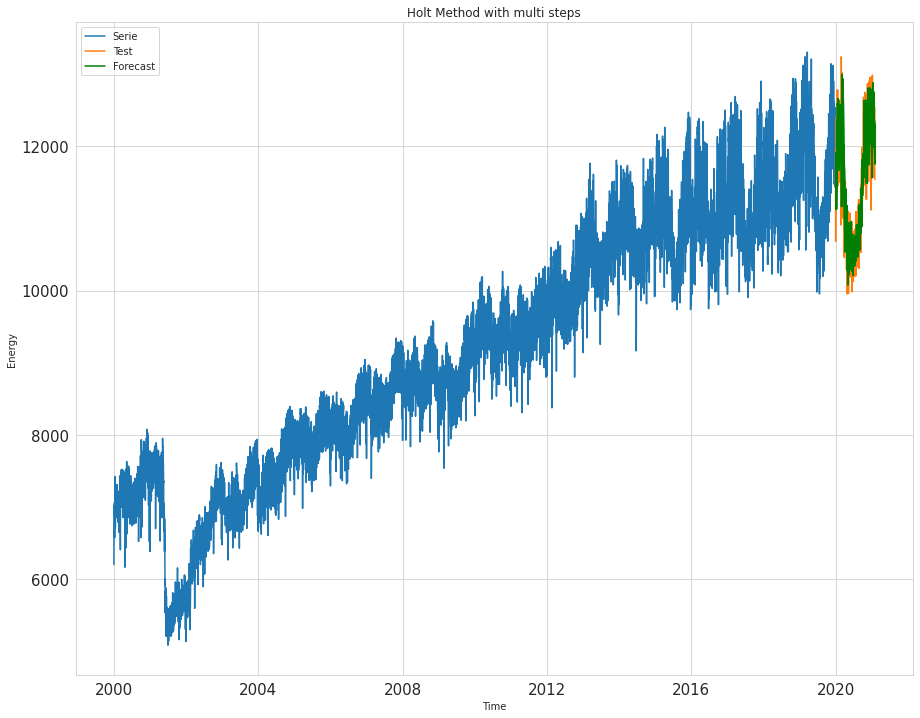

In [141]:
def simple_exp_smoothing(train, alpha, n_steps=1):
    estimated = SimpleExpSmoothing(train, initialization_method="estimated")
    _fit = estimated.fit(smoothing_level=alpha, optimized=False)
    return _fit.forecast(n_steps)

n_steps = 7
n_forecasts = len(test_vv) - n_steps + 1

for i in range(n_forecasts):
    forecast = simple_exp_smoothing(train_vv, 0.6, n_steps)
    pred.append(forecast)

    obs = test_vv[i]
    train_vv.append(obs)
    pred_exp.append([forecast[0], obs])

def evaluate_forecasts(test, forecasts, n_steps):
    sum_rmse = 0
    sum_mape = 0
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]

        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        mape = sqrt(mean_absolute_error(ytrue_ts, ypred_ts))
        sum_rmse += rmse
        sum_mape += mape
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape}")
    print(f"Média RMSE: {sum_rmse/n_steps}")
    print(f"Média MAPE: {sum_mape/n_steps}")

evaluate_forecasts(test_vv, pred, n_steps)

print("Ultimos 10 valores:")
for item in pred_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, label='truth')
ax.plot(test.index[n_steps-1:], pred, color='green')
plt.legend(['Serie', 'Test', 'Forecast'])
plt.ylabel('Energy')
plt.xlabel('Time')
plt.title('Holt Method with multi steps')

## 7.2 Suavização exponencial Holt-Winter

RMSE: 391.103 | MAPE:  17
Ultimos 10 valores:
Predito=12274.935618232012, Esperado=12367.506
Predito=12357.046956517428, Esperado=11874.637
Predito=12212.50104841861, Esperado=11568.613
Predito=11991.323374186855, Esperado=12271.288
Predito=12099.224177964088, Esperado=12550.309
Predito=12254.853292850408, Esperado=12308.892
Predito=12240.813203885169, Esperado=12550.095
Predito=12287.777948550698, Esperado=12413.574
Predito=12361.781936495358, Esperado=11988.032
Predito=12297.204864798781, Esperado=11540.266


Text(0.5, 1.0, 'Holt Winter')

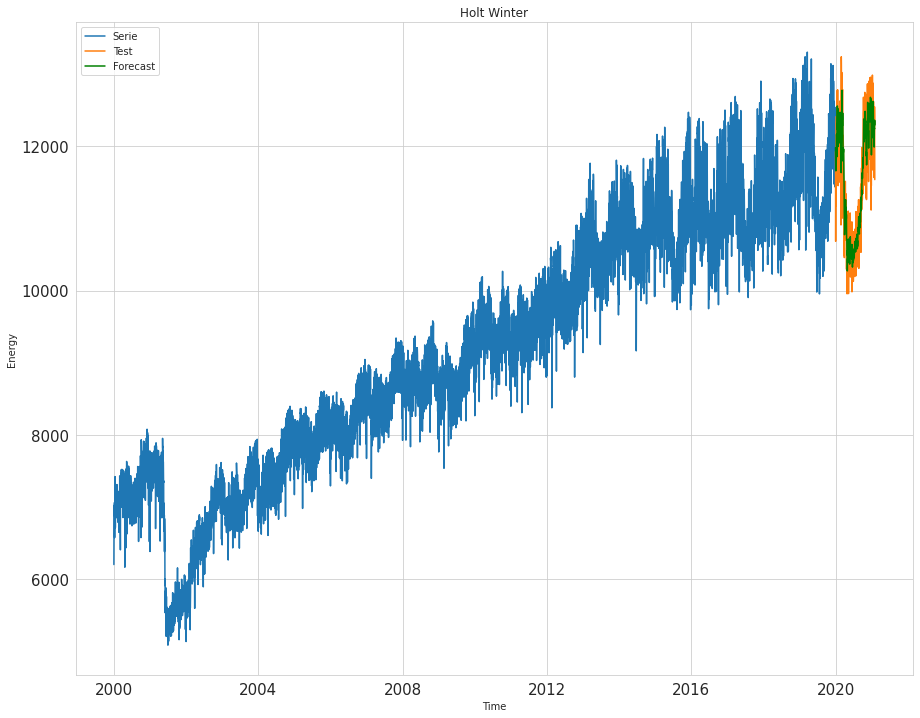

In [142]:
test_vv = test_v.values
train_vv = [x for x in train_v]

def holt_winter_method(train, n_steps=0):
    estimated = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated")
    _fit = estimated.fit(optimized=True)
    return _fit.forecast(n_steps)


pred = list()
pred_exp = list()
for i in range(len(test_vv)):
    # Predict
    forecast = holt_winter_method(train_vv)
    pred.append(forecast)

    obs = test_vv[i]
    train_vv.append(obs)
    pred_exp.append([forecast[0], obs])

rmse = sqrt(mean_squared_error(test_vv, pred))
mape = sqrt(mean_absolute_error(test_vv, pred))
print('RMSE: %.3f | MAPE: %3.f' % (rmse, mape))

print("Ultimos 10 valores:")
for item in pred_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, label='truth')
ax.plot(test.index, pred, color='green')

plt.legend(['Serie', 'Test', 'Forecast'])
plt.ylabel('Energy')
plt.xlabel('Time')
plt.title('Holt Winter')